In [1]:
import os
import pandas as pd
import re

## **1. Xây dựng bộ dữ liệu**

Dữ liệu ban đầu gồm 11 folders: doi-song, du-lich, giai-tri, giao-duc, khoa-hoc, kinh-doanh, phap-luat, suc-khoe, the-gioi, the-thao, thoi-su được cào từ trang báo VNExpress. Trong mỗi folder chứa các file txt là nội dung 1 bài báo.

Ta sẽ tiến hành tách các bài báo thành các câu riêng biệt. Sau đó, xoá dấu ở các câu để tạo bộ dữ liệu cho bài toán. Mỗi bản ghi trong bộ dữ liệu sẽ là 1 câu trong đoạn văn và câu tương ứng sau khi đã bỏ dấu.

In [ ]:
def split_into_sentences(text):
    sentence_endings = re.compile(r'(?<!\.)\.(?!\.)|\?|\!')
    sentences = sentence_endings.split(text)

    sentences = [sent.strip() for sent in sentences if sent.strip()]

    return sentences 

In [ ]:
def process_folder(folder_path):
    sentences = []
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".txt"):
                file_path = os.path.join(root, filename)
                with open(file_path, "r", encoding="utf-8") as file:
                    lines = file.readlines()
                    if lines:
                        title = lines[0].strip()
                        sentences.append(title)  
                        text = " ".join([line.strip() for line in lines[1:] if line.strip()])  
                        if not re.search(r'[\.!?]$', text):
                            text += "."
                        sentences.extend(split_into_sentences(text)) 
    return sentences

In [ ]:
main_folder_path = "/kaggle/input/vietnamese-sentences/data/results"  
all_sentences = process_folder(main_folder_path)

df = pd.DataFrame(all_sentences, columns=["Sentence"])


In [5]:
df

,Sentence
0,Ngôi đền cho người đồng tính
1,"Đài Loan Đền Tu'er Shen ở thành phố Tân Bắc, t..."
2,Đền Tu'er Shen được lập năm 2006 bởi một người...
3,"Công trình khá khiêm tốn, nằm trong một con hẻ..."
4,Nơi đây là điểm lui tới thường xuyên cho những...
...,...
179063,"Nếu không có biện pháp, Việt Nam có thể thiệt ..."
179064,Việt Nam cần đầu tư 368 tỷ USD để ứng phó biến...
179065,"""Vì vậy, cử tri mong có chương trình mang tầm ..."
179066,"Ngày 14/10, mưa lớn suốt 6 giờ do hoàn lưu trư..."


In [ ]:
import unicodedata

def remove_vietnamese_accents(text):
    text = unicodedata.normalize('NFD', text)
    text = ''.join([c for c in text if unicodedata.category(c) != 'Mn'])
    text = text.replace('đ', 'd').replace('Đ', 'D')
    return text

df['Sentence_Without_Accents'] = df['Sentence'].apply(remove_vietnamese_accents)


In [7]:
df

,Sentence,Sentence_Without_Accents
0,Ngôi đền cho người đồng tính,Ngoi den cho nguoi dong tinh
1,"Đài Loan Đền Tu'er Shen ở thành phố Tân Bắc, t...","Dai Loan Den Tu'er Shen o thanh pho Tan Bac, t..."
2,Đền Tu'er Shen được lập năm 2006 bởi một người...,Den Tu'er Shen duoc lap nam 2006 boi mot nguoi...
3,"Công trình khá khiêm tốn, nằm trong một con hẻ...","Cong trinh kha khiem ton, nam trong mot con he..."
4,Nơi đây là điểm lui tới thường xuyên cho những...,Noi day la diem lui toi thuong xuyen cho nhung...
...,...,...
179063,"Nếu không có biện pháp, Việt Nam có thể thiệt ...","Neu khong co bien phap, Viet Nam co the thiet ..."
179064,Việt Nam cần đầu tư 368 tỷ USD để ứng phó biến...,Viet Nam can dau tu 368 ty USD de ung pho bien...
179065,"""Vì vậy, cử tri mong có chương trình mang tầm ...","""Vi vay, cu tri mong co chuong trinh mang tam ..."
179066,"Ngày 14/10, mưa lớn suốt 6 giờ do hoàn lưu trư...","Ngay 14/10, mua lon suot 6 gio do hoan luu tru..."


In [8]:
df.to_csv('/kaggle/working/data_vn.csv')

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

sentences_no_accents = df['Sentence_Without_Accents'].tolist()
sentences_with_accents = df['Sentence'].tolist()

## **2. Sử dụng character-based approach**

In [10]:
tokenizer = Tokenizer(char_level=True, filters='', lower=False)  
tokenizer.fit_on_texts(sentences_no_accents + sentences_with_accents)

vocab_size = len(tokenizer.word_index) + 1

In [11]:
sequences_no_accents = tokenizer.texts_to_sequences(sentences_no_accents)
sequences_with_accents = tokenizer.texts_to_sequences(sentences_with_accents)

In [12]:
max_length = max(max(len(seq) for seq in sequences_no_accents),
                 max(len(seq) for seq in sequences_with_accents))

padded_no_accents = pad_sequences(sequences_no_accents, maxlen=max_length, padding='post')
padded_with_accents = pad_sequences(sequences_with_accents, maxlen=max_length, padding='post')

In [13]:
padded_no_accents.shape

(179068, 1432)

In [14]:
split_idx = int(0.8 * len(padded_no_accents))
X_train, X_test = padded_no_accents[:split_idx], padded_no_accents[split_idx:]
y_train, y_test = padded_with_accents[:split_idx], padded_with_accents[split_idx:]


## **3. Xây dựng mô hình**

### **3.1. Mô hình 1**

**Xây dựng mô hình ban đầu gồm 3 lớp: Embedding, LSTM, Dense.**

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train = np.array(X_train)
y_train = np.expand_dims(np.array(y_train), axis=-1)
X_test = np.array(X_test)
y_test = np.expand_dims(np.array(y_test), axis=-1)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

Epoch 1/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 420s 186ms/step - accuracy: 0.9790 - loss: 0.1282 - val_accuracy: 0.9933 - val_loss: 0.0212
Epoch 2/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 425s 190ms/step - accuracy: 0.9945 - loss: 0.0184 - val_accuracy: 0.9947 - val_loss: 0.0173
Epoch 3/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 427s 191ms/step - accuracy: 0.9955 - loss: 0.0154 - val_accuracy: 0.9954 - val_loss: 0.0152
Epoch 4/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 427s 191ms/step - accuracy: 0.9961 - loss: 0.0135 - val_accuracy: 0.9959 - val_loss: 0.0137
Epoch 5/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 427s 191ms/step - accuracy: 0.9966 - loss: 0.0119 - val_accuracy: 0.9964 - val_loss: 0.0124
Epoch 6/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 428s 191ms/step - accuracy: 0.9969 - loss: 0.0113 - val_accuracy: 0.9966 - val_loss: 0.0118
Epoch 7/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 428s 191ms/step - accuracy: 0.9971 - loss: 0.0103 - val_accuracy: 0.9967 - val_loss: 0.0113
Epoch 8/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 428s 191ms/step - ac

**Thời gian huấn luyện mô hình: ~6h30m**

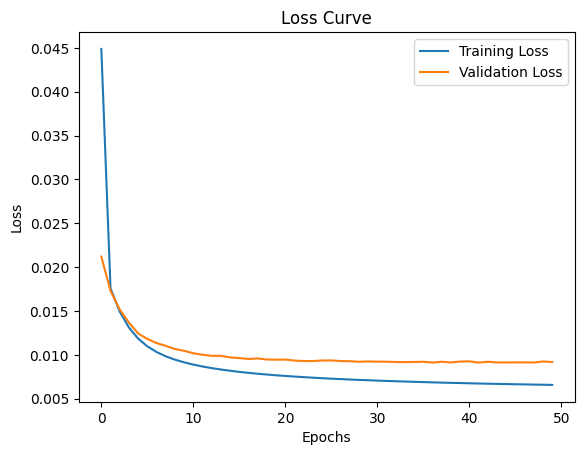

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [ ]:
def restore_diacritics(text):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
    prediction = model.predict(padded_seq)
    predicted_seq = np.argmax(prediction, axis=-1)[0]
    restored_text = ''.join([tokenizer.index_word[idx] for idx in predicted_seq if idx != 0])
    return restored_text

# Kiểm tra mô hình
example_text = "ban co muon di choi voi toi khong"
restored_text = restore_diacritics(example_text)
print(f"Input: {example_text}")
print(f"Restored: {restored_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Input: ban co muon di choi voi toi khong
Restored: ban có muốn đi chơi với tôi không


**Nhận xét: Mô hình cho kết quả chưa hoàn toàn chính xác. Do đó, ta sẽ thêm một số lớp vào kiến trúc để cải thiện khả năng dự đoán cho mô hình.**

In [ ]:
model.save("/kaggle/working/vietnamese_diacritics_model.h5")

### **3.2. Mô hình 2**

Thêm vào mô hình hai lớp:
- LSTM: tăng khả năng dự đoán
- Dropout: tránh bị overfitting khi ta tăng thêm độ phức tạp cho mô hình.

In [15]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),  
    Dropout(0.2), 
    Bidirectional(LSTM(64, return_sequences=True)), 
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
X_train = np.array(X_train)
y_train = np.expand_dims(np.array(y_train), axis=-1)
X_test = np.array(X_test)
y_test = np.expand_dims(np.array(y_test), axis=-1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=3,           
    restore_best_weights=True 
)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
4477/4477 ━━━━━━━━━━━━━━━━━━━━ 910s 202ms/step - accuracy: 0.9773 - loss: 0.1385 - val_accuracy: 0.9951 - val_loss: 0.0158
Epoch 2/50
4477/4477 ━━━━━━━━━━━━━━━━━━━━ 905s 202ms/step - accuracy: 0.9957 - loss: 0.0143 - val_accuracy: 0.9965 - val_loss: 0.0113
Epoch 3/50
4477/4477 ━━━━━━━━━━━━━━━━━━━━ 905s 202ms/step - accuracy: 0.9968 - loss: 0.0107 - val_accuracy: 0.9972 - val_loss: 0.0093
Epoch 4/50
4477/4477 ━━━━━━━━━━━━━━━━━━━━ 905s 202ms/step - accuracy: 0.9974 - loss: 0.0091 - val_accuracy: 0.9976 - val_loss: 0.0083
Epoch 5/50
4477/4477 ━━━━━━━━━━━━━━━━━━━━ 905s 202ms/step - accuracy: 0.9977 - loss: 0.0082 - val_accuracy: 0.9978 - val_loss: 0.0076
Epoch 6/50
4477/4477 ━━━━━━━━━━━━━━━━━━━━ 905s 202ms/step - accuracy: 0.9978 - loss: 0.0078 - val_accuracy: 0.9979 - val_loss: 0.0072
Epoch 7/50
4477/4477 ━━━━━━━━━━━━━━━━━━━━ 905s 202ms/step - accuracy: 0.9980 - loss: 0.0072 - val_accuracy: 0.9980 - val_loss: 0.0069
Epoch 8/50
4477/4477 ━━━━━━━━━━━━━━━━━━━━ 905s 202ms/step - ac

**Thời gian huấn luyện mô hình: ~10h41m**

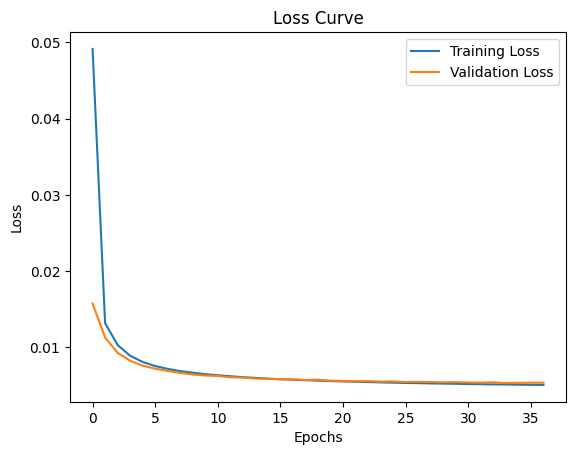

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [19]:
def restore_diacritics(text):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
    prediction = model.predict(padded_seq)
    predicted_seq = np.argmax(prediction, axis=-1)[0]
    restored_text = ''.join([tokenizer.index_word[idx] for idx in predicted_seq if idx != 0])
    return restored_text

# Kiểm tra mô hình
example_text = "ban co muon di choi voi toi khong"
restored_text = restore_diacritics(example_text)
print(f"Input: {example_text}")
print(f"Restored: {restored_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Input: ban co muon di choi voi toi khong
Restored: bạn có muốn đi chơi với tôi không


**Nhận xét: Mô hình đã cho kết quả tốt hơn mô hình ban đầu.**

In [20]:
model.save("/kaggle/working/vietnamese_diacritics_model_v2.h5")